In [70]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-aebuawgb
  Running setup.py bdist_wheel for NVCCPlugin ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-h3h8ik63/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [71]:
%load_ext nvcc_plugin
%pylab inline

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin
Populating the interactive namespace from numpy and matplotlib


In [149]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148


![alt text](https://docs.nvidia.com/cuda/cuda-c-programming-guide/graphics/grid-of-thread-blocks.png)

```
  Maximum y- or z-dimension of a grid of thread blocks	65535
  Maximum dimensionality of thread block	              3
  Maximum x- or y-dimension of a block	                1024
  Maximum z-dimension of a block	                      64
  Maximum number of threads per block	                 1024
  Warp size	                                           32

CUDA Device Query (Runtime API) version (CUDART static linking)

  Maximum number of threads per multiprocessor:  2048
  Maximum number of threads per block:           1024
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)
  Maximum memory pitch:                          2147483647 bytes
```


In [0]:
#@title Paremeters
Number_of_particles = 25600 #@param {type:"slider", min:0, max:1024000, step:1024}
Particle = "alpha" #@param ["p", "alpha", "n", "t", "Li"]
Energy = 20 #@param {type:"slider", min:0, max:1000, step:10}
Target = "Fe2O3" #@param ["CH4", "C12H18O7", "TiT20", "SiO2", "Fe2O3", "LiF"]

if Particle=="p":
    ParticleChoise=1
if Particle=="alpha":
    ParticleChoise=2
if Particle=="n":
    ParticleChoise=3
if Particle=="t":
    ParticleChoise=4
if Particle=="Li":
    ParticleChoise=5
    
    
if Target=="CH4":
    TargetChoise=1
if Target=="C12H18O7":
    TargetChoise=2
if Target=="TiT20":
    TargetChoise=3
if Target=="SiO2":
    TargetChoise=4
if Target=="Fe2O3":
    TargetChoise=5
if Target=="LiF":
    TargetChoise=6

text = """
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <curand_kernel.h>
#include <fstream>
#include <iostream>
#include <math.h>
#include <stdlib.h>
#include <ctime>
#include <math.h>
#include <string>

#define BLOCKS 1024
#define THREADS """+str(int(Number_of_particles/1024))+"""

using namespace std;

#define CUDA_CALL(x) do { if((x) != cudaSuccess) {   cout<<"Error"<<endl;  return EXIT_FAILURE;}} while(0)

// ------------------------------------------
__device__ double V_func(double x, double par0, double par1, double par2){
    return par0 * par1 * 14.4 / x * par2;
}

__device__ double Vshtrih_func(double x, double par0, double par1, double par2, double par3, double par4) {
    return par0 * par1 * 14.4 / x * (par2 / par3 - par4 / x);
}

__device__ double FI_func(double x) {
    return 0.1818 * exp(-3.2 * x) + 0.5099 * exp(-0.9432 * x) + 0.2802 * exp(-0.4029 * x) + 0.0282 * exp(-0.2016 * x);
}
__device__ double FIshtrih_func(double x) {
    return -(0.1818 * 3.2 * exp(-3.2 * x) + 0.5099 * 0.9432 * exp(-0.9432 * x) + 0.2802 * 0.4029 * exp(-0.4029 * x) + 0.0282 * 0.2016 * exp(-0.2016 * x));
}

__device__ double f_func(double x, double par0, double par1, double par2) {
    return 1 - par0 / par1 - (par2 / x) * (par2 / x);
}

__device__ double fshtrih_func(double x, double par0, double par1, double par2) {
    return -par0 / par1 + 2 * par2 * par2 / (x * x * x);
}

__device__ double sinkvtetanadva(double p, double E, double M1, double M2, int Z1, int Z2) {
    double a = 0.88534 * 0.529 / (pow(Z1, 0.23) + pow(Z2, 0.23));
    a = a * (-0.003 * (pow(Z1, 0.5) + pow(Z2, 0.5)) + 0.98);

    double B = p / a;
    double Ec = E / (1 + M1 / M2);

    double rm = a;
    double V_out;
    double Vshtrih_out;
    for (int gggg = 0; gggg < 20; gggg++) {
        double FI_out = FI_func(rm / a);
        double FIshtrih_out = FIshtrih_func(rm / a);
        V_out = V_func(rm, Z1, Z2, FI_out);
        Vshtrih_out = Vshtrih_func(rm, Z1, Z2, FIshtrih_out, a, FI_out);
        double fshtrih_out = fshtrih_func(rm, Vshtrih_out, Ec, p);
        double f_out = f_func(rm, V_out, Ec, p);
        rm = rm - f_out / fshtrih_out;
    }
    double ro = -2 * (Ec - V_out) / Vshtrih_out;
    double Rm = rm / a;
    double Rc = ro / a;
    double Esm = M2 / (M1 + M2) * E;
    double epsilon = a * Esm / (Z1 * Z2 * 14.4);
    double alfa = 1 + 0.75984 * pow(epsilon, -0.5);
    double beta = (5.71974 + pow(epsilon, 0.5)) / (6.14171 + pow(epsilon, 0.5));
    double gamma = (9.5217 + epsilon) / (6.2612 + epsilon);
    double A = 2 * alfa * epsilon * pow(B, beta);
    double G = gamma / (powf((1 + A * A), 0.5) - A);

    double delta = A * (Rm - B) / (1 + G);

    if (((B + Rc + delta) / (Rm + Rc) < 1) && ((B + Rc + delta) / (Rm + Rc) > -1)) {
        double theta = 2 * acosf((B + Rc + delta) / (Rm + Rc));
        return (sinf(theta / 2) * sinf(theta / 2));
    } else {
        return 1 / (1 + 2 * epsilon * B * 2 * epsilon * B);
    }
}
//-----------------------------------------------

__global__ void setup_kernel(curandState *state)
{
    int id = threadIdx.x + blockIdx.x * blockDim.x;
    /* Each thread gets different seed, a different sequence
       number, no offset */
    curand_init(7+id, id, 0, &state[id]);
}


__global__ void generate_kernel(curandState *state,
                                float *result)
{   
    int id = threadIdx.x + blockIdx.x * blockDim.x;
   
    /* Copy state to local memory for efficiency */
    curandState localState = state[id];
    
     
        
    
    int p="""+str(ParticleChoise)+""";
    double M1,Z1;
    
    if(p==1)
    M1=1; Z1=1;
    
    if(p==2)
    M1=4; Z1=2;
    
    if(p==3)
    M1=2; Z1=1;
    
    if(p==4)
    M1=3; Z1=7;
    
    if(p==5)
    M1=3; Z1=1;
    
    
    
    
    double E="""+str(Energy)+""";
    
    int Target="""+str(TargetChoise)+""";
    int n;
    double M1m,Z1m;//aem,г/моль
    double M2m,Z2m;//aem,г/моль
    double M3m,Z3m;//aem,г/моль
    double w[10];
    double mu[10];
    double ro;
    
    
    if(Target==1)
    {
       n=2;
       M1m=12;Z1m=6;
       M2m=1;Z2m=1;
       w[0]=1./5; w[1]=4./5;
       mu[0]=12; mu[1]=1;
       ro=0.02;
    }
    
    if(Target==2)
    {
       n = 3;
       M1m = 12; Z1m = 6;
       M2m = 1; Z2m = 1;
       M3m = 16; Z3m = 8;
       w[0]=12./37; w[1]=18./37; w[2]=7./37;
       mu[0]=12;    mu[1]=1;     mu[2]=16;
       ro = 1.32;
    }
    
    
    if(Target==3)
    {
    
     n=2;
     M1m=47.8;Z1m=22;//aem,г/моль
     M2m=3;Z2m=1;//aem,г/моль
     w[0]=1./3;   w[1]=2./3;
     mu[0]=47.8;  mu[1]=3;
     ro=1.94;
    }
    
    if(Target==4)
    {
       n=2;
      M1m=28;Z1m=14;//aem,г/моль
      M2m=16;Z2m=8;//aem,г/моль
      w[0]=1./3; w[1]=2./3;
      mu[0]=28;  mu[1]=16;
      ro=2.64;
    }
    
    
    if(Target==5)
    {
      n=2;
      M1m=55.8; Z1m=26;
      M2m=16; Z2m=8;
      w[0]=2./5; w[1]=3./5;
      mu[0]=55.8;mu[1]=16;
      ro=5.24;
    }
    
    if(Target==6)
    {
    
    n=2;
    M1m=6.94; Z1m=3;//aem,г/моль
    M2m=19; Z2m=9;//aem,г/моль
    w[0]=1./2;w[1]=1./2;
    mu[0]=55.8;mu[1]=16;
    ro=2.63;
    }
    
    double x0 = 0, y0 = 0, z0 = 0;
    double omegaX1 = 1, omegaY1 = 0, omegaZ1 = 0;
    double omegaX2, omegaY2, omegaZ2;
    double Na = 6.02e23;
    


    double Mu = 0;

    for (int ta = 0; ta < n; ta++) {
        Mu = Mu + w[ta] * mu[ta];
    }
    double n0 = ro / Mu * Na;

    double L = pow(n0, -1. / 3);

    double ksi; // random number
    
    double M2, Z2;
    double x, y, z;

    
    int z1mi = 0;
    int z2mi = 0;
    int z3mi = 0;
    double length = 0;
    while (E > 10) {

        double wpar[100];
        wpar[0] = w[0];

        for (int i = 1; i < n; i++) {
            wpar[i] = wpar[i - 1] + w[i];
        }
        
        // -------UNIFORM-----------------
        ksi = (curand_uniform(&localState));
        
        int k = 0;
        while (ksi > wpar[k]) k++;

        int prtn = k;

        if (prtn == 0) {
            Z2 = Z1m;
            M2 = M1m;
            z1mi++;
        }
        if (prtn == 1) {
            Z2 = Z2m;
            M2 = M2m;
            z2mi++;
        }
        
        if (prtn == 2) {
            Z2 = Z3m;
            M2 = M3m;
            z3mi++;
        }
        // -------UNIFORM-----------------
        ksi = (curand_uniform(&localState));
        
        double p = sqrt(ksi / 3.1415 / pow(n0, 2. / 3)) * 1e8;

        double Emax = 4 * M1 * M2 / pow((M1 * M2), 2) * E;
        double skt = sinkvtetanadva(p, E, M1, M2, Z1, Z2);
        
        double teta = 2 * asin(sqrt(skt));
        double E2 = Emax * skt;

        double alfa = 1.88 / 1000 * pow(Z1 + Z2, 5. / 3) * sqrt(E / M1);
        double beta = 0.3042 * pow((Z1 + Z2), 1. / 3);
        double deltaE = alfa / pow(1 + beta * p, 5);

        double Tetalab = atan(sin(teta) / (cos(teta) + M1 / M2));
        double muuuu = cos(Tetalab);
        
        // -------UNIFORM-----------------
        ksi = curand_uniform(&localState);

        double fi = 2 * 3.1415 * ksi;

        omegaX2 = omegaX1 * muuuu - (omegaY1 * sin(fi) + omegaX1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaY2 = omegaY1 * muuuu + (omegaX1 * sin(fi) - omegaY1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaZ2 = omegaZ1 * muuuu + (1 - omegaZ1 * omegaZ1) * cos(fi) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);

        x = L * omegaX2 + x0;
        y = L * omegaY2 + y0;
        z = L * omegaZ2 + z0;

        k++;

        x0 = x;
        y0 = y;
        z0 = z;
        
        length += sqrt(x*x+y*y+z*z);

        omegaX1 = omegaX2;
        omegaY1 = omegaY2;
        omegaZ1 = omegaZ2;

        E = E - E2 - deltaE;
        
    }
    /* Copy state back to global memory */
    state[id] = localState;
    /* Store last generated result per thread */
    double translation = sqrt(x*x+y*y+z*z);
    result[id] = translation;
    //result[id] = length;
}


int main(int argc, char *argv[])
{
    clock_t start, finish;
    start = std::clock();
    
    int i;
    double total;
    curandState *devStates;
    float *devResults, *hostResults;
    int device;
    struct cudaDeviceProp properties;


    CUDA_CALL(cudaGetDevice(&device));
    CUDA_CALL(cudaGetDeviceProperties(&properties,device));
    

    //////////////////////////////////////////////
    /* Allocate space for results on host       */
    /* Виділити простір для результатів на хості*/
    //////////////////////////////////////////////
    
    hostResults = (float *)calloc(THREADS * BLOCKS, sizeof(float));
    
    ////////////////////////////////////////////////
    /* Allocate space for results on device       */
    /* Виділити простір для результатів на девайсі*/
    ////////////////////////////////////////////////
    
    CUDA_CALL(cudaMalloc((void **)&devResults, BLOCKS * THREADS *
              sizeof(float)));
    
    ////////////////////////////////////////////////
    /* Set results to 0                           */
    /* Встановити результати до 0                 */
    ////////////////////////////////////////////////
    
    CUDA_CALL(cudaMemset(devResults, 0, THREADS * BLOCKS *
              sizeof(float)));

    //////////////////////////////////////////////////////////////
    /* Allocate space for pseudorandom states on device         */
    /* Виділити простір для псевдовипадкових станів на пристрої */
    //////////////////////////////////////////////////////////////
    
    CUDA_CALL(cudaMalloc((void **)&devStates, THREADS * BLOCKS *
                  sizeof(curandState)));
    
    
  
    ///////////////////////////////
    /* Setup pseudorandom states */
    ///////////////////////////////
    
    setup_kernel<<<BLOCKS, THREADS>>>(devStates);
    
    
    
    /////////////////////////////////////////////
    /* Generate and use uniform pseudo-random  */
    /////////////////////////////////////////////
    
    generate_kernel<<<BLOCKS, THREADS>>>(devStates, devResults);
    
    
    ////////////////////////////////
    /* Copy device memory to host */
    ////////////////////////////////
    
    CUDA_CALL(cudaMemcpy(hostResults, devResults, BLOCKS * THREADS *
        sizeof(float), cudaMemcpyDeviceToHost));
    
    finish = std::clock();
    
    
    
    
    cout<<"time: "<<(finish - start)/ (double) CLOCKS_PER_SEC<<"  ";
    
    /////////////////
    /* Show result */
    /////////////////
    
    cout<<"Threads: "<<THREADS<<"   Blocks: "<< BLOCKS<<"   Particles: "<<THREADS*BLOCKS;
 
    
    
    ofstream myfile;
    myfile.open ("translations.txt");
    for (int i=0; i<THREADS*BLOCKS; i++ )
    {
        myfile <<hostResults[i]<<endl;
    }
    myfile.close();

    
    total = 0;
    for(i = 0; i < BLOCKS * THREADS; i++) {
        total += hostResults[i];
    }
    
    cout<<"  Results mean = "<< (total/(1.0*BLOCKS*THREADS))*10000000;

    /* Cleanup */
    CUDA_CALL(cudaFree(devStates));
    CUDA_CALL(cudaFree(devResults));
    free(hostResults);
    return EXIT_SUCCESS;
}

"""

path = 'penetration.cu'
file = open(path,'w')
file.write(text)
file.close()

#!cat penetration.cu

In [272]:
!nvcc -arch=sm_30 penetration.cu -o executable
!./executable

time: 0.156639  Threads: 25   Blocks: 1024   Particles: 25600  Results mean = 3.1421

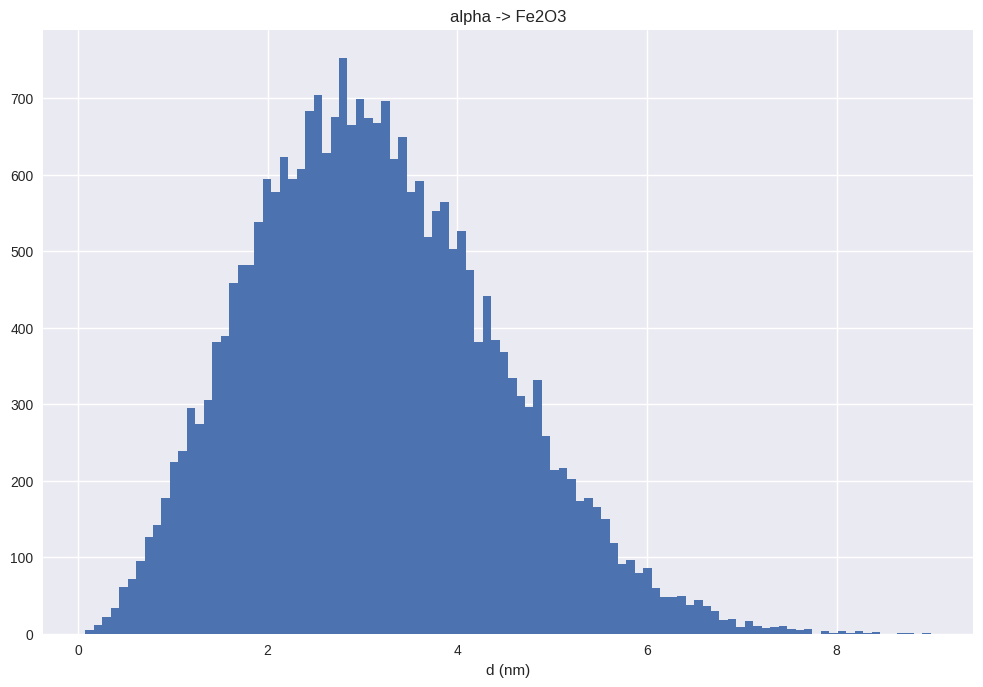

In [273]:
import numpy as np
import matplotlib.pyplot as plt

ress = np.loadtxt("translations.txt")
new_ress = [i * 10000000 for i in ress]
plt.figure(figsize=(12,8), dpi=100)
plt.xlabel('d (nm)')

plt.title(Particle+" -> "+Target)
#plt.text( 16.5,5000,r'N='+str(len(new_ress)), fontsize=20)
plt.hist(new_ress, bins=100);
plt.grid(True)
plt.show()


In [282]:
text=f"""
#include <fstream>
#include <iostream>
#include <math.h>
#include <stdlib.h>
#include <ctime>
#include <random>
#include <string>

using namespace std;

double V_func(double x, double par0, double par1, double par2)"""+"""{
    return par0 * par1 * 14.4 / x * par2;
}

double Vshtrih_func(double x, double par0, double par1, double par2, double par3, double par4) {
    return par0 * par1 * 14.4 / x * (par2 / par3 - par4 / x);
}

double FI_func(double x) {
    return 0.1818 * exp(-3.2 * x) + 0.5099 * exp(-0.9432 * x) + 0.2802 * exp(-0.4029 * x) + 0.0282 * exp(-0.2016 * x);
}
double FIshtrih_func(double x) {
    return -(0.1818 * 3.2 * exp(-3.2 * x) + 0.5099 * 0.9432 * exp(-0.9432 * x) + 0.2802 * 0.4029 * exp(-0.4029 * x) + 0.0282 * 0.2016 * exp(-0.2016 * x));
}

double f_func(double x, double par0, double par1, double par2) {
    return 1 - par0 / par1 - (par2 / x) * (par2 / x);
}

double fshtrih_func(double x, double par0, double par1, double par2) {
    return -par0 / par1 + 2 * par2 * par2 / (x * x * x);
}

double sinkvtetanadva(double p, double E, double M1, double M2, int Z1, int Z2) {
    long double a = 0.88534 * 0.529 / (pow(Z1, 0.23) + pow(Z2, 0.23));
    a = a * (-0.003 * (pow(Z1, 0.5) + pow(Z2, 0.5)) + 0.98);

    long double B = p / a;
    long double Ec = E / (1 + M1 / M2);

    long double rm = a;
    double V_out;
    double Vshtrih_out;
    for (int gggg = 0; gggg < 20; gggg++) {
        double FI_out = FI_func(rm / a);
        double FIshtrih_out = FIshtrih_func(rm / a);
        V_out = V_func(rm, Z1, Z2, FI_out);
        Vshtrih_out = Vshtrih_func(rm, Z1, Z2, FIshtrih_out, a, FI_out);
        double fshtrih_out = fshtrih_func(rm, Vshtrih_out, Ec, p);
        double f_out = f_func(rm, V_out, Ec, p);
        rm = rm - f_out / fshtrih_out;
    }
    long double ro = -2 * (Ec - V_out) / Vshtrih_out;
    long double Rm = rm / a;
    long double Rc = ro / a;
    long double Esm = M2 / (M1 + M2) * E;
    long double epsilon = a * Esm / (Z1 * Z2 * 14.4);
    long double alfa = 1 + 0.75984 * pow(epsilon, -0.5);
    long double beta = (5.71974 + pow(epsilon, 0.5)) / (6.14171 + pow(epsilon, 0.5));
    long double gamma = (9.5217 + epsilon) / (6.2612 + epsilon);
    long double A = 2 * alfa * epsilon * pow(B, beta);
    long double G = gamma / (pow((1 + A * A), 0.5) - A);

    long double delta = A * (Rm - B) / (1 + G);

    if (((B + Rc + delta) / (Rm + Rc) < 1) && ((B + Rc + delta) / (Rm + Rc) > -1)) {
        long double theta = 2 * acos((B + Rc + delta) / (Rm + Rc));
        return (sin(theta / 2) * sin(theta / 2));
    } else {
        return 1 / (1 + 2 * epsilon * B * 2 * epsilon * B);
    }
}

default_random_engine generator;
uniform_real_distribution < double > distribution(0.0, 1.0);

int partner(int n, double * w) {

    double wpar[100];
    wpar[0] = w[0];

    for (int i = 1; i < n; i++) {
        wpar[i] = wpar[i - 1] + w[i];
        //cout << wpar[i] << "  ";
    }

    double ksi = distribution(generator);

    int k = 0;
    while (ksi > wpar[k]) k++;

    return (k);
}

float do_interact(int par,int Target, double E) {
    
    double M1,Z1;
    
    if(par==1)
    M1=1; Z1=1;
    
    if(par==2)
    M1=4; Z1=2;
    
    if(par==3)
    M1=2; Z1=1;
    
    if(par==4)
    M1=3; Z1=7;
    
    if(par==5)
    M1=3; Z1=1;
    
    
    
    

    int n;
    double M1m,Z1m;//aem,г/моль
    double M2m,Z2m;//aem,г/моль
    double M3m,Z3m;//aem,г/моль
    double w[10];
    double mu[10];
    double ro;
    
    
    if(Target==1)
    {
       n=2;
       M1m=12;Z1m=6;
       M2m=1;Z2m=1;
       w[0]=1./5; w[1]=4./5;
       mu[0]=12; mu[1]=1;
       ro=0.02;
    }
    
    if(Target==2)
    {
       n = 3;
       M1m = 12; Z1m = 6;
       M2m = 1; Z2m = 1;
       M3m = 16; Z3m = 8;
       w[0]=12./37; w[1]=18./37; w[2]=7./37;
       mu[0]=12;    mu[1]=1;     mu[2]=16;
       ro = 1.32;
    }
    
    
    if(Target==3)
    {
    
     n=2;
     M1m=47.8;Z1m=22;//aem,г/моль
     M2m=3;Z2m=1;//aem,г/моль
     w[0]=1./3;   w[1]=2./3;
     mu[0]=47.8;  mu[1]=3;
     ro=1.94;
    }
    
    if(Target==4)
    {
       n=2;
      M1m=28;Z1m=14;//aem,г/моль
      M2m=16;Z2m=8;//aem,г/моль
      w[0]=1./3; w[1]=2./3;
      mu[0]=28;  mu[1]=16;
      ro=2.64;
    }
    
    
    if(Target==5)
    {
      n=2;
      M1m=55.8; Z1m=26;
      M2m=16; Z2m=8;
      w[0]=2./5; w[1]=3./5;
      mu[0]=55.8;mu[1]=16;
      ro=5.24;
    }
    
    if(Target==6)
    {
    
    n=2;
    M1m=6.94; Z1m=3;//aem,г/моль
    M2m=19; Z2m=9;//aem,г/моль
    w[0]=1./2;w[1]=1./2;
    mu[0]=55.8;mu[1]=16;
    ro=2.63;
    }


    double x0 = 0, y0 = 0, z0 = 0;
    double omegaX1 = 1, omegaY1 = 0, omegaZ1 = 0;
    double omegaX2, omegaY2, omegaZ2;
    double Na = 6.02e23;

    double Mu = 0;

    for (int ta = 0; ta < n; ta++) {
        Mu = Mu + w[ta] * mu[ta];
    }
    double n0 = ro / Mu * Na;
    //cout << "no= " << n0 << " сm^-3" << endl;
    double L = pow(n0, -1. / 3);
    //cout << "L= " << L << " сm" << endl;
    double ksi;
    double M2, Z2;
    double x, y, z;

    int k = 0;
    int z1mi = 0;
    int z2mi = 0;
    int z3mi = 0;

    while (E > 10) {

        ksi = distribution(generator);
        int prtn = partner(n, w);

        if (prtn == 0) {
            Z2 = Z1m;
            M2 = M1m;
            z1mi++;
        }
        
        if (prtn == 1) {
            Z2 = Z2m;
            M2 = M2m;
            z2mi++;
        }
        if (prtn == 2) {
            Z2 = Z3m;
            M2 = M3m;
            z3mi++;
        }

        ksi = distribution(generator);
        double p = sqrt(ksi / 3.1415 / pow(n0, 2. / 3)) * 1e8;

        double Emax = 4 * M1 * M2 / pow((M1 * M2), 2) * E;
        double skt = sinkvtetanadva(p, E, M1, M2, Z1, Z2);
        //cout << "p= " << p << "A, E= " << E << "keV, M1= " << M1 << " M2= " << M2 << " Z1= " << Z1 << " Z2= " << Z2 << endl;
        //cout << "skt= " << skt << endl;
        double teta = 2 * asin(sqrt(skt));
        double E2 = Emax * skt;

        double alfa = 1.88 / 1000 * pow(Z1 + Z2, 5. / 3) * sqrt(E / M1);
        double beta = 0.3042 * pow((Z1 + Z2), 1. / 3);
        double deltaE = alfa / pow(1 + beta * p, 5);

        double Tetalab = atan(sin(teta) / (cos(teta) + M1 / M2));
        double muuuu = cos(Tetalab);
        ksi = distribution(generator);

        double fi = 2 * 3.1415 * ksi;

        omegaX2 = omegaX1 * muuuu - (omegaY1 * sin(fi) + omegaX1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaY2 = omegaY1 * muuuu + (omegaX1 * sin(fi) - omegaY1 * omegaZ1 * cos(fi)) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);
        omegaZ2 = omegaZ1 * muuuu + (1 - omegaZ1 * omegaZ1) * cos(fi) * pow(((1 - muuuu * muuuu) / (1 - omegaZ1 * omegaZ1)), 0.5);

        x = L * omegaX2 + x0;
        y = L * omegaY2 + y0;
        z = L * omegaZ2 + z0;

        k++;

        x0 = x;
        y0 = y;
        z0 = z;
        //cout << "X= " << x << "Y= " << y << "Z= " << z << endl;

        omegaX1 = omegaX2;
        omegaY1 = omegaY2;
        omegaZ1 = omegaZ2;

        E = E - E2 - deltaE;
        //cout << "E= " << E << endl << endl;
    }
    return sqrt(x*x+y*y+z*z);
}


int main(){
    int n = """+str(Number_of_particles)+""";
    int p="""+str(ParticleChoise)+""";
    double E="""+str(Energy)+""";
    int Target="""+str(TargetChoise)+""";
    clock_t start, finish;
    start = std::clock();
    double l=0;
    
    for (int i=0; i<n; i++){
        l+=do_interact(p,Target,E);
    }
    
    finish = std::clock();
        
    cout<<"time: "<<(finish - start)/ (double) CLOCKS_PER_SEC<<"  "<<"Results mean"<<l/n*10000000;
    
    return 0;
}
"""
path = "penetration.cpp"
file = open(path,'w')
file.write(text)
file.close()
 
debug="exeReg"
!g++ $path -o $debug
!./$debug

time: 10.2636  Results mean3.15706